# Importing Packages

In [1]:
import numpy as np
import pandas as pd
import math
import os
import matplotlib as mpl
import matplotlib.pyplot as plt
import mplcyberpunk
from sklearn import preprocessing
from matplotlib.transforms import Affine2D
from matplotlib import font_manager
import mpl_toolkits.axisartist.floating_axes as floating_axes
import warnings
warnings.filterwarnings("ignore")
from adjustText import adjust_text
from mplsoccer import FontManager

# Loading Data

In [2]:
df_outfielders = pd.read_csv('D:\Analytics\Football\Barcalytix\Data\Big5Leagues2021-22_Outfielders.csv')
df_player_positions = pd.read_csv(r'D:\Analytics\Football\Barcalytix\Data\fbref_to_tm_mapping.csv')
df_team_possession = pd.read_csv(r'D:\Analytics\Football\Barcalytix\Data\Big5Leagues2021-22_Teams_Poss.csv')

# Data Prep

Adding the suffix '_Team' to Team Possession stats

In [3]:
df_team_possession = df_team_possession.add_suffix('_Team')

Merging the datasets

In [4]:
df = pd.merge(df_outfielders,df_player_positions,how='left',left_on=['player'],right_on=['PlayerFBref'])

In [5]:
df = pd.merge(df,df_team_possession,how='left',left_on=['squad'],right_on=['Squad_Team'])

Filtering the data

In [6]:
df = df[(df['TmPos']=='Centre-Back')&(df['minutes_90s']>=10)]
df.reset_index(inplace=True,drop=True)

### Calculating New Metrics

**1.Progression Load:**<br>
$$\\frac{\text{Progressive Actions of a Player}}{\text{Total Progressive Actions of the team}}\$$ <br>
Used to calculate how much the player is contributing to the team's progression.
<br>
<br>

**2.Touch Volume in Open Play:**<br>
$$\\frac{\text{Touches taken by the Player in Open Play}}{\text{Total Touches taken by the team in Open Play}}\$$ <br>
Used to calculate how much the player possesses the ball relative to the team's in possession.
<br>
<br>

**3.Ball Retention:**<br>
$$\frac{\text{Miscontrols + Dispossessions}}{\text{Carries}} + \frac{\text{Passes Blocked + Passes Intercepted}}{\text{Passes Attempted}}$$ <br>
Used to calculate how much a player turns over the ball. 

In [7]:
df['Prog. Load'] = ((df['progressive_passes']+df['progressive_carries'])/(df['Prog. Actions_Team']))
df['Touch Volume OP'] = (df['touches_live_ball']/df['Live_Team'])
df['Ball retention'] = ((df['miscontrols']+df['dispossessed'])/df['carries'])+((df['passes_blocked']+df['passes_intercepted'])/df['passes'])

In [8]:
df_viz = df[['player','Prog. Load','Touch Volume OP','Ball retention']]

Standardizing the metrics

In [9]:
StandardScaler = preprocessing.StandardScaler()
df_viz['prog_load_std'] = StandardScaler.fit_transform(df['Prog. Load'].values.reshape(-1,1))
df_viz['vol_touches_OP_std'] = StandardScaler.fit_transform(df['Touch Volume OP'].values.reshape(-1,1))

# Visualization

In [10]:
mpl.rcParams['axes.edgecolor']='#5f5e69'
mpl.rcParams['xtick.color']='#5f5e69'
mpl.rcParams['ytick.color']='#5f5e69'
mpl.rcParams['axes.labelsize']=20
mpl.rcParams['axes.linewidth']=2

In [11]:
rubik_normal = FontManager(("https://github.com/googlefonts/rubik/blob/main/fonts/ttf/Rubik-Regular.ttf?raw=true"))
rubik_medium = FontManager(("https://github.com/googlefonts/rubik/blob/main/fonts/ttf/Rubik-Medium.ttf?raw=true"))
rubik_bold = FontManager(("https://github.com/googlefonts/rubik/blob/main/fonts/ttf/Rubik-Bold.ttf?raw=true"))

In [12]:
# Function to translte/rotate points
def translate(x,y,a): 
    x_new = x*math.cos(a)-y*math.sin(a)
    y_new = x*math.sin(a)+y*math.cos(a)
    return [x_new,y_new]

In [13]:
#Functions to set colors and edgeColors of the Scatter Plot
def fillColor(x,y):
    if x>0.5 and y>0.5:
        return '#ffba42'
    elif x>0.5 and y<0.5:
        return '#329682'
    elif x<0.5 and y>0.5:
        return '#96b4c8'
    elif x<0.5 and y<0.5:
        return 'None'

def edgeColor(x,y):
    if x>0.5 and y>0.5:
        return '#ffba42'
    elif x>0.5 and y<0.5:
        return '#329682'
    elif x<0.5 and y>0.5:
        return '#96b4c8'
    elif x<0.5 and y<0.5:
        return '#b3603d'

In [14]:
df_viz['fillColor'] = df_viz.apply(lambda x:fillColor(x['prog_load_std'],x['vol_touches_OP_std']),axis=1)
df_viz['edgeColor'] = df_viz.apply(lambda x:edgeColor(x['prog_load_std'],x['vol_touches_OP_std']),axis=1)

In [15]:
# Rotating the points since we rotate the axes
df_viz['x_rot'] = df_viz['prog_load_std']*math.cos(math.pi/4)-df_viz['vol_touches_OP_std']*math.sin(math.pi/4)
df_viz['y_rot'] = df_viz['prog_load_std']*math.sin(math.pi/4)+df_viz['vol_touches_OP_std']*math.cos(math.pi/4)

In [16]:
# Selecting players with high scores in the metrics
player_list=[]

player_list = player_list+(list(df_viz.sort_values('Prog. Load',ascending=False).head(5)['player']))
player_list = player_list+list(df_viz.sort_values('Touch Volume OP',ascending=False).head(5)['player'])
player_list = player_list+list(df_viz.sort_values('Ball retention').head(5)['player'])

In [17]:
# Selecting players of choice
select_players = ['Eric García','Dayot Upamecano','Marquinhos','Ronald Araújo','David Alaba','Virgil van Dijk','Rúben Dias','Éder Militão']
player_list = player_list+select_players

In [18]:
# Filtering out the Last Names of the players
df_labels = df_viz[df_viz['player'].isin(player_list)]
df_labels['LName'] = [i[-1] for i in list(df_labels['player'].str.split(' '))]
df_labels.reset_index(inplace=True,drop=True)

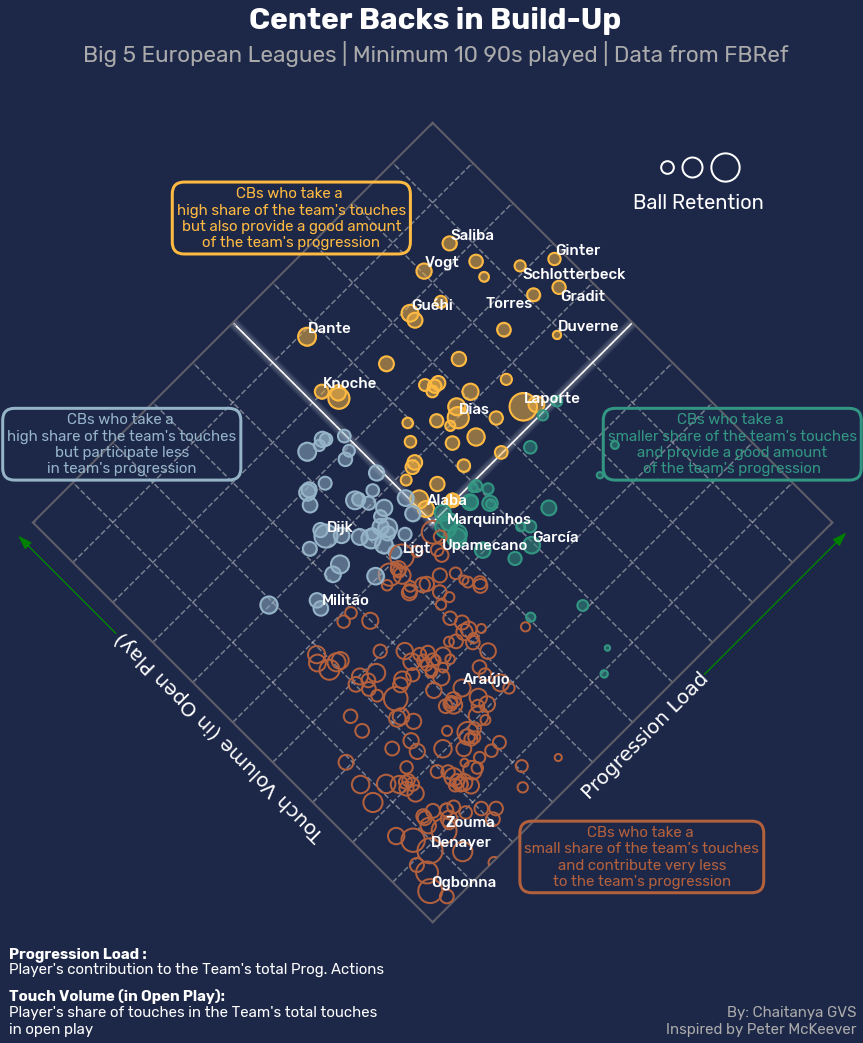

In [20]:
fig = plt.figure(figsize=(15,15))
fig.set_facecolor('#1d2849')

plot_extents = -2, 3, -2, 3
transform = Affine2D().rotate_deg(45) # Rotating the axes 
helper = floating_axes.GridHelperCurveLinear(transform, plot_extents)
ax = floating_axes.FloatingSubplot(fig, 111, grid_helper=helper)
ax.patch.set_facecolor('#1d2849')
ax.grid(color='#d6d6d6',which='major',linestyle='--',alpha=0.5,linewidth=1.5)


fig.add_subplot(ax)

plt.xticks(np.linspace(df_viz['prog_load_std'].min(),df_viz['prog_load_std'].max(),11))
plt.yticks(np.linspace(df_viz['vol_touches_OP_std'].min(),df_viz['vol_touches_OP_std'].max(),11))

# Plotting the scatter points
for index,row in df_viz.iterrows():
    ax.scatter(row.x_rot,row.y_rot,
               s=8/df_viz['Ball retention'][index],
               color=row.fillColor,
               alpha=.5,
               zorder=3)
    ax.scatter(row.x_rot,row.y_rot,
               s=8/df_viz['Ball retention'][index],
               color='None',
               edgeColor=row.edgeColor,lw=2,
               alpha=1,
               zorder=3)
    
# Adding labels of the select players
labels = [plt.text(df_labels['x_rot'][i],df_labels['y_rot'][i],s=df_labels['LName'][i],fontsize=15,c='w',fontproperties=rubik_medium.prop) for i in range(len(df_labels))]
adjust_text(labels)

# Adding text boxes to each quadrant
plt.text(-1.25,3.15,
         s='CBs who take a \nhigh share of the team\'s touches\nbut also provide a good amount\nof the team\'s progression' ,
         fontdict=dict(c='#ffba42',fontsize=15,ha='center',fontproperties=rubik_normal.prop),
         bbox=dict(facecolor='None',alpha=1,boxstyle=('round,rounding_size=0.8'),linewidth=3,
                   edgecolor='#ffba42'))
plt.text(2.65,1.15,
         s='CBs who take a \nsmaller share of the team\'s touches\nand provide a good amount\nof the team\'s progression' ,
         fontdict=dict(c='#329682',fontsize=15,ha='center',fontproperties=rubik_normal.prop),
         bbox=dict(facecolor='None',alpha=1,boxstyle=('round,rounding_size=0.8'),linewidth=3,
                   edgecolor='#329682'))
plt.text(-2.75,1.15,
         s='CBs who take a \nhigh share of the team\'s touches\nbut participate less\nin team\'s progression' ,
         fontdict=dict(c='#96b4c8',fontsize=15,ha='center',fontproperties=rubik_normal.prop),
         bbox=dict(facecolor='None',alpha=1,boxstyle=('round,rounding_size=0.8'),linewidth=3,
                   edgecolor='#96b4c8'))
plt.text(1.85,-2.5,
         s='CBs who take a \nsmall share of the team\'s touches\nand contribute very less\nto the team\'s progression' ,
         fontdict=dict(c='#b3603d',fontsize=15,ha='center',fontproperties=rubik_normal.prop),
         bbox=dict(facecolor='None',alpha=1,boxstyle=('round,rounding_size=0.8'),linewidth=3,
                   edgecolor='#b3603d'))

# Highlighting the first quadrant
ax.plot([translate(0.5,0.5,math.pi/4)[0],translate(0.5,3,math.pi/4)[0]],
        [translate(0.5,0.5,math.pi/4)[1],translate(0.5,3,math.pi/4)[1]],c='w')
ax.plot([translate(0.5,0.5,math.pi/4)[0],translate(3,.5,math.pi/4)[0]],
        [translate(0.5,0.5,math.pi/4)[1],translate(3,.5,math.pi/4)[1]],c='w')
mplcyberpunk.make_lines_glow()

ax.arrow(translate(1.25,-2.15,math.pi/4)[0],translate(1.25,-2.15,math.pi/4)[1],
         translate(1.65,0,math.pi/4)[0],translate(1.65,0,math.pi/4)[1],
         clip_on=False,color='green',head_width=0.075)
ax.arrow(translate(-2.175,1.785,math.pi/4)[0],translate(-2.175,1.785,math.pi/4)[1],
         translate(0,1.1,math.pi/4)[0],translate(0,1.1,math.pi/4)[1],
         clip_on=False,color='green',head_width=0.075)
ax.set_aspect('equal')

plt.xlabel("Progression Load",c='w',fontproperties=rubik_bold.prop)
plt.ylabel("Touch Volume (in Open Play)",c='w',fontproperties=rubik_bold.prop)
# ax.tick_params(axis='y', labelrotation=180)
ax.axis[:].major_ticklabels.set_visible(False)

# Adding the heading
fig.text(0.515,0.99-.03,s='Center Backs in Build-Up', fontsize=30, fontweight='bold',c='w',ha='center',fontproperties=rubik_bold.prop)
fig.text(0.515,0.96-.03,s='Big 5 European Leagues | Minimum 10 90s played | Data from FBRef', fontsize=22.5, fontweight='medium',c='#ababab',ha='center',fontproperties=rubik_normal.prop)

# Size Legend
ax2 = fig.add_axes([0.625,0.775,0.255,0.075])
ax2.get_xaxis().set_visible(False)
ax2.get_yaxis().set_visible(False)
ax2.set_facecolor('#1d2849')
ax2.spines['right'].set_visible(False)
ax2.spines['top'].set_visible(False)
ax2.spines['bottom'].set_visible(False)
ax2.spines['left'].set_visible(False)
ax2.set_xlim(0,100)
ax2.set_ylim(0,100)
ax2.set_zorder(0)

ax2.scatter(41,76,edgecolors='white',s=80*2, c='#1d2849',lw=2)
ax2.scatter(50,76,edgecolors='white',s=200*2, c='#1d2849',lw=2)
ax2.scatter(62,76,edgecolors='white',s=400*2, c='#1d2849',lw=2)
ax2.text(52.5,25,s='Ball Retention',fontsize=20,c='w',ha='center',fontproperties=rubik_normal.prop)

# Explaining the metrics
fig.text(0.12,0.1,'Progression Load :' ,c='w',fontsize=15,fontproperties=rubik_bold.prop)
fig.text(0.12,0.085,'Player\'s contribution to the Team\'s total Prog. Actions' ,c='w',fontsize=15,fontproperties=rubik_normal.prop)
fig.text(0.12,0.06,'Touch Volume (in Open Play):' ,c='w',fontsize=15,fontproperties=rubik_bold.prop)
fig.text(0.12,0.03,'Player\'s share of touches in the Team\'s total touches\nin open play' ,c='w',fontsize=15,fontproperties=rubik_normal.prop)

# Adding the credits
fig.text(0.905,0.03,'By: Chaitanya GVS\nInspired by Peter McKeever' ,c='#ababab',fontsize=15,fontproperties=rubik_normal.prop,ha='right')
fig.savefig("D:\Analytics\Football\Barcalytix\Figures\360ScoutingAssignment.png",bbox_inches='tight',dpi=200)

plt.show()